In [1]:
import torch 
import numpy as np
import collections
import time
import pickle 
from tqdm import tqdm

import sys
import os

os.environ['CUDA_VISIBLE_DEVICES']='3'

sys.path.append('engine/')
sys.path.append('funcs/')
sys.setrecursionlimit(10000)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

from Model import *
from eval_funcs import *
from plot_funcs import *
from utils import *
from csv_utils import *
from tifffile import *

data_folder = os.getenv('HOME')+'/Mackebox/Artur/WorkDB/deepstorm/datasets/'

In [2]:
'''2D low SNR'''
# name = 'decode_2d_low'  
# eval_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N2.HD-2D-Exp.tif'
# train_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT4.N2.HD-2D-Exp.tif'
# psf_fit_file = None
# psf_params =  {'width1':1.1, 'width2':5., 'w_prop':0.6, 'z_scale':5, 'modality':'GAUSS_2D'}
# scale =  10.
# z_prior =  [0.,1.5]

'''2D high SNR'''
# name = 'decode_2d_high'  
# eval_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N1.HD-2D-Exp.tif'
# train_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N1.HD-2D-Exp.tif'
# psf_fit_file = None
# psf_params =  {'width1':1.1, 'width2':5., 'w_prop':0.6, 'z_scale':5, 'modality':'GAUSS_2D'}
# scale =  100.
# z_prior =  [0.,1.5]

'''AS low SNR'''
name = 'decode_as_low' 
eval_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N2.HD-AS-Exp.tif'
train_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT4.N2.HD-AS-Exp.tif'
psf_fit_file = 'psf_chall_as.pkl'
scale =  10
z_prior =  [0,0.5]

'''AS high SNR'''
# name = 'decode_as_high'  
# eval_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N1.HD-AS-Exp.tif'
# train_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT2.N1.HD-AS-Exp.tif'
# psf_fit_file = 'psf_chall_as_5.pkl'
# scale =  100.
# z_prior =  [0,0.5]

'''DH low SNR'''
# name = 'decode_dh_low'  
# eval_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N2.HD-DH-Exp.tif'
# train_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT4.N2.HD-DH-Exp.tif'
# psf_fit_file = 'psf_chall_dh_5.pkl'
# scale =  30.
# z_prior =  [0,0.5]

'''DH high SNR'''
# name = 'decode_dh_high'  
# eval_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT0.N1.HD-DH-Exp.tif'
# train_dataset = data_folder + '/SMLM_2016/sequence-as-stack-MT2.N1.HD-DH-Exp.tif'
# psf_fit_file = 'psf_chall_dh_5.pkl'
# scale =  300.
# z_prior =  [0,0.5]

'DH high SNR'

In [3]:
'''Combined learning'''
train_mode = 'co'
global_context = True

'''Simulator learning'''
# train_mode = 'sl'
# global_context = False

'Simulator learning'

In [4]:
train_images = imread(train_dataset)
eval_images  = imread(eval_dataset)
eval_csv = read_csv(data_folder + '/SMLM_2016/activations_HD_N2.csv')

bg_train, _ = get_bg_stats(train_images)
bg_test, _ = get_bg_stats(eval_images)

eval_images = eval_images + (bg_train - bg_test)

In [5]:
batch_size = 10
n_samples = 40
win_size = 40

rec_params = {}

rec_params['n_filters'] = 48
rec_params['factor'] = train_images.mean(0).max().astype('float32')
rec_params['offset'] = train_images.mean().astype('float32')
rec_params['global_context'] = global_context
rec_params['local_context'] = True
rec_params['bg_pred'] = False
rec_params['sig_pred'] = True

if psf_fit_file:
    psf_params = {}
    with open(psf_fit_file, 'rb') as f:
        psf_fit = pickle.load(f)
    psf_params = psf_fit['psf_params']
    del(psf_params['beads_fit'])
else:
    psf_params = psf_params

psf_params['scale'] = scale

ll_params = {}
ll_params['baseline'] = 100
ll_params['theta'] = gpu([2*300/45])
ll_params['backg'] = bg_train
ll_params['p_act'] = 0.05
ll_params['p_lambda'] = 0.05
ll_params['surv_p'] = 0.5
ll_params['z_prior'] = z_prior
ll_params['prior_fac'] = 2.
ll_params['min_int'] = 0.1

model = Model(rec_params, psf_params, ll_params)

model.train_mode = train_mode

if psf_fit_file:
    model.mgen.w_map = psf_fit['w_map']
    model.wobble = psf_fit['wobble']
    model.fixed_psf = True

model.window_map = get_window_map(train_images,win_size, 20)
model.eval_csv = eval_csv
model.eval_imgs = eval_images[:250]

model.warm_up = 1000

model.filename = name

In [ ]:
model.fit(train_images, batch_size=batch_size,n_samples=n_samples, win_size=win_size, max_iters=50000, learning_rate = 6e-4, print_freq=500, print_output=True)

/groups/turaga/home/speisera/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


JoR: 0.565 || Eff_3d: 12.455 || Jaccard: 0.200 || Factor: 11.344 || RMSE: 35.407 || Cost: nan || Recall: 0.200 || Precision: 1.000 || Time Upd.: 225.3 || BatchNr.: 250
JoR: 0.735 || Eff_3d: 19.476 || Jaccard: 0.285 || Factor: 10.150 || RMSE: 38.699 || Cost: nan || Recall: 0.285 || Precision: 0.992 || Time Upd.: 228.8 || BatchNr.: 500
JoR: 0.865 || Eff_3d: 27.103 || Jaccard: 0.385 || Factor: 11.269 || RMSE: 44.543 || Cost: nan || Recall: 0.387 || Precision: 0.991 || Time Upd.: 234.0 || BatchNr.: 750
JoR: 0.969 || Eff_3d: 30.342 || Jaccard: 0.427 || Factor: 14.800 || RMSE: 44.069 || Cost: 7787.675 || Recall: 0.430 || Precision: 0.984 || Time Upd.: 232.5 || BatchNr.: 1001
JoR: 0.916 || Eff_3d: 30.146 || Jaccard: 0.471 || Factor: 11.320 || RMSE: 51.393 || Cost: 7823.413 || Recall: 0.488 || Precision: 0.931 || Time Upd.: 905.1 || BatchNr.: 1501
JoR: 0.946 || Eff_3d: 30.222 || Jaccard: 0.480 || Factor: 11.982 || RMSE: 50.688 || Cost: 7795.661 || Recall: 0.490 || Precision: 0.957 || Time Upd.

Text(0, 0.5, '3D efficiency')

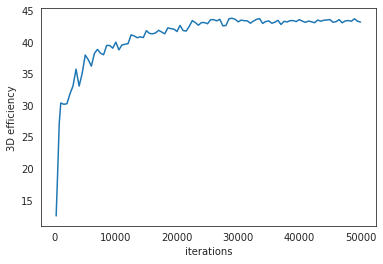

In [144]:
plot_od(model.col_dict['eff_3d'])
plt.xlabel('iterations')
plt.ylabel('3D efficiency')

In [126]:
arr_infs = decode_func(model,eval_images,250,use_tqdm=True, z_scale=model.mgen.psf_pars['z_scale'], int_scale=model.mgen.psf_pars['scale'])

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


In [135]:
nms_sampling(arr_infs, threshold=0.7, batch_size=2500, nms=True, nms_cont=False)
rescale(arr_infs, 20, sig_3d=False)
preds = array_to_list(arr_infs, wobble=model.wobble)
preds = filt_preds(preds,90,is_3d=True)
tol = 500 if '3D' in model.mgen.psf_pars['modality'] else np.inf

In [136]:
match_dict, matches= matching(eval_csv, preds, print_res=True, min_int=False, tolerance_ax=tol)

Recall: 0.617
Precision: 0.979
Jaccard: 60.874
RMSE_lat: 48.956
RMSE_ax: 63.189
RMSE_vol: 79.935
Jaccard/RMSE: 1.243
Eff_lat: 37.331
Eff_ax: 49.711
Eff_3d: 43.521
FN: 10420.0 FP: 354.0


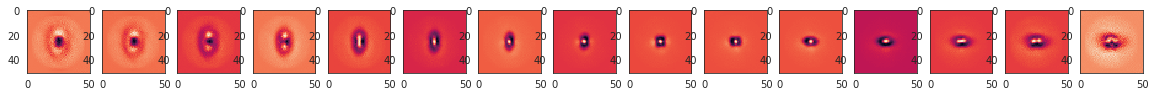

In [139]:
plt.figure(figsize=(20,5))
for i in range(1,len(model.mgen.w_map)+1):
    plt.subplot(1,len(model.mgen.w_map),i)
    plt.imshow(cpu(model.mgen.w_map)[i-1])

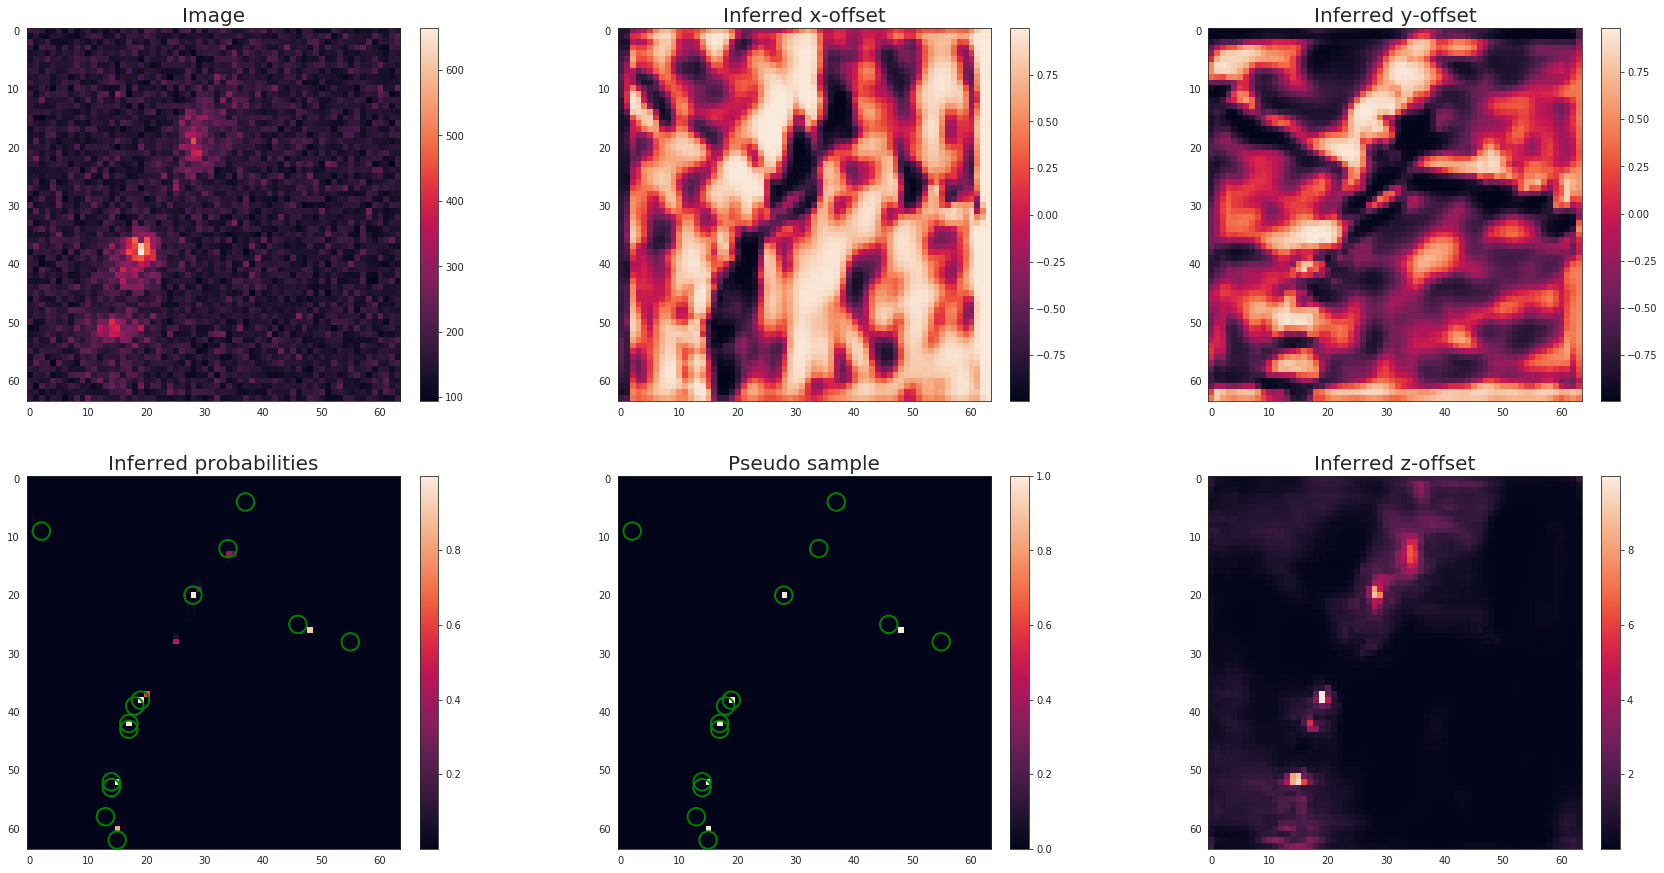

In [140]:
from matplotlib.patches import Circle

pseudo_samp = arr_infs['Samples_ps']

fig, ax_arr = plt.subplots(2,3, figsize=(30,30))
plt.subplots_adjust(bottom=0.5)
ax = []
datas = [] 
plts = []
for i in ax_arr:
    for j in i:
        ax.append(j)
        
datas.append(eval_images)
datas.append(arr_infs['XO'])
datas.append(arr_infs['YO'])
datas.append(arr_infs['Probs'])
datas.append(pseudo_samp)
datas.append(arr_infs['Int'])

titles = ['Image', 'Inferred x-offset', 'Inferred y-offset', 'Inferred probabilities','Pseudo sample', 'Inferred z-offset']

ind = 45

for i in range(len(ax)):
    plts.append(ax[i].imshow(datas[i][ind]))
    ax[i].set_title(titles[i], fontsize = 20)
    plt.colorbar(plts[i], ax=ax[i], fraction=0.046, pad=0.04)

for x,y in zip(locs['Samples'][ind].nonzero()[0],locs['Samples'][ind].nonzero()[1]):
    circ = plt.Circle((y,x), radius=1.5, color='g', fill=False, lw=2)
    ax[3].add_patch(plt.Circle((y,x), radius=1.5, color='g', fill=False, lw=2))
    ax[4].add_patch(plt.Circle((y,x), radius=1.5, color='g', fill=False, lw=2))

(-324.8247536399942,
 6582.345111912796,
 -6727.9160376108775,
 -37.701529736146085)

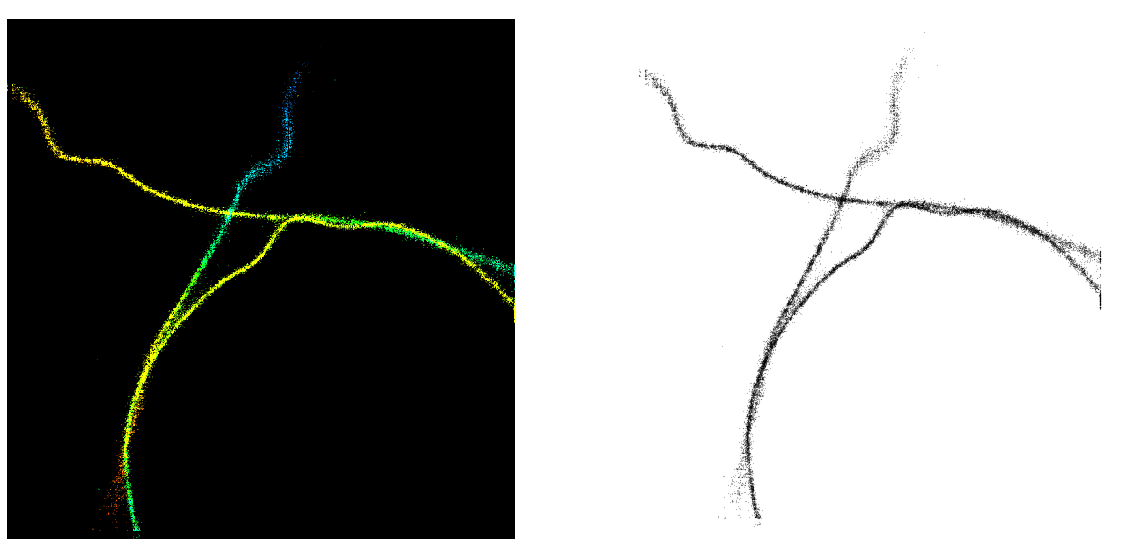

In [141]:
if '3D' in model.mgen.psf_pars['modality']:
    hist_img = create_3d_hist(preds, z_clip=[-700,700], pix_size=5, sigma=5, contrast_fac=20)
else:
    hist_img = create_2d_hist(preds, pix_size=5, sigma=5, contrast_fac=5)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(hist_img)
plt.axis('off')
plt.subplot(122)
plt.scatter(np.array(preds)[:,2],-np.array(preds)[:,3],s=0.01,color='black')
plt.axis('off')